In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
from pathlib import Path
import anndata as ad
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
from matplotlib import pyplot as plt

sys.path.insert(0, "/home/ylu/project/spateo-release_new")
import spateo_dev as st
sys.path.insert(0, "/home/ylu/project")
from utils import *

os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

%load_ext autoreload
%autoreload 2

2024-08-14 17:32:36.330030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 17:32:36.620382: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-14 17:32:36.620409: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-08-14 17:32:37.794159: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [2]:
data_folder = "../../data/BARseq/BARseq_Perturbed/"
results_folder = "./results/Spateo_mesh/"
figures_folder = "./results/figures/Spateo_mesh"
Path(results_folder).mkdir(parents=True, exist_ok=True)

In [3]:
slices = [ad.read_h5ad(data_folder + "slice_{:0>2d}.h5ad".format(i)) for i in range(1, 41)]

In [6]:
transformation = np.load('./results/processed_results/Spateo_transformation.npy', allow_pickle=True).item()
align_Rotation = transformation['align_Rotation']
align_translation = transformation['align_translation']

In [9]:
slices[0]

AnnData object with n_obs × n_vars = 34029 × 114
    obs: 'cluster', 'slice_id', 'simplify_cluster'
    obsm: 'align_spatial', 'perturbed_spatial', 'spatial', 'spatial_CCF', 'spatial_raw'

In [11]:
from tqdm import tqdm
cur_R = np.eye(2)
cur_t = np.zeros(2)
for i in tqdm(range(len(slices))):
    slices[i].obsm['align_spatial'] = slices[i].obsm['perturbed_spatial'] @ cur_R.T + cur_t
    if i < len(slices)-1:
        R = align_Rotation[i]
        t = align_translation[i]
        cur_t = t @ cur_R.T + cur_t
        cur_R = cur_R @ R

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 564.02it/s]


In [17]:
z_values = []
for i in range(len(slices)):
    z_values.append(np.mean(slices[i].obsm['spatial_CCF'][:,2]))

In [58]:
import pyvista as pv
brain_mesh = pv.read('../../data/HalfAdultMouseBrain.vtk')

In [59]:
brain_mesh_align = st.tdr.scale_model(model=brain_mesh, scale_factor=40, scale_center=None, inplace=False)
brain_mesh_align = st.tdr.rotate_model(model=brain_mesh_align, angle=(0, 0, 90), rotate_center= brain_mesh.center, inplace=False)

In [60]:
z_shift_correction = st.align.z_shift_correction(
    models=slices,
    mesh=brain_mesh_align,
    spatial_key='align_spatial',
    key_added='align_spatial_z_corrected',
    z_values=z_values,
)

In [61]:
z_shift_correction.extract_contours(method='alpha', smoothing=True, window_size=3, outlier_threshold=30, alpha=0.2, n_sampling=10000)

|-----> [Extract contours of slices, method: alpha.] in progress: 100.0000%
|-----> [Extract contours of slices, method: alpha.] finished [81.1426s]


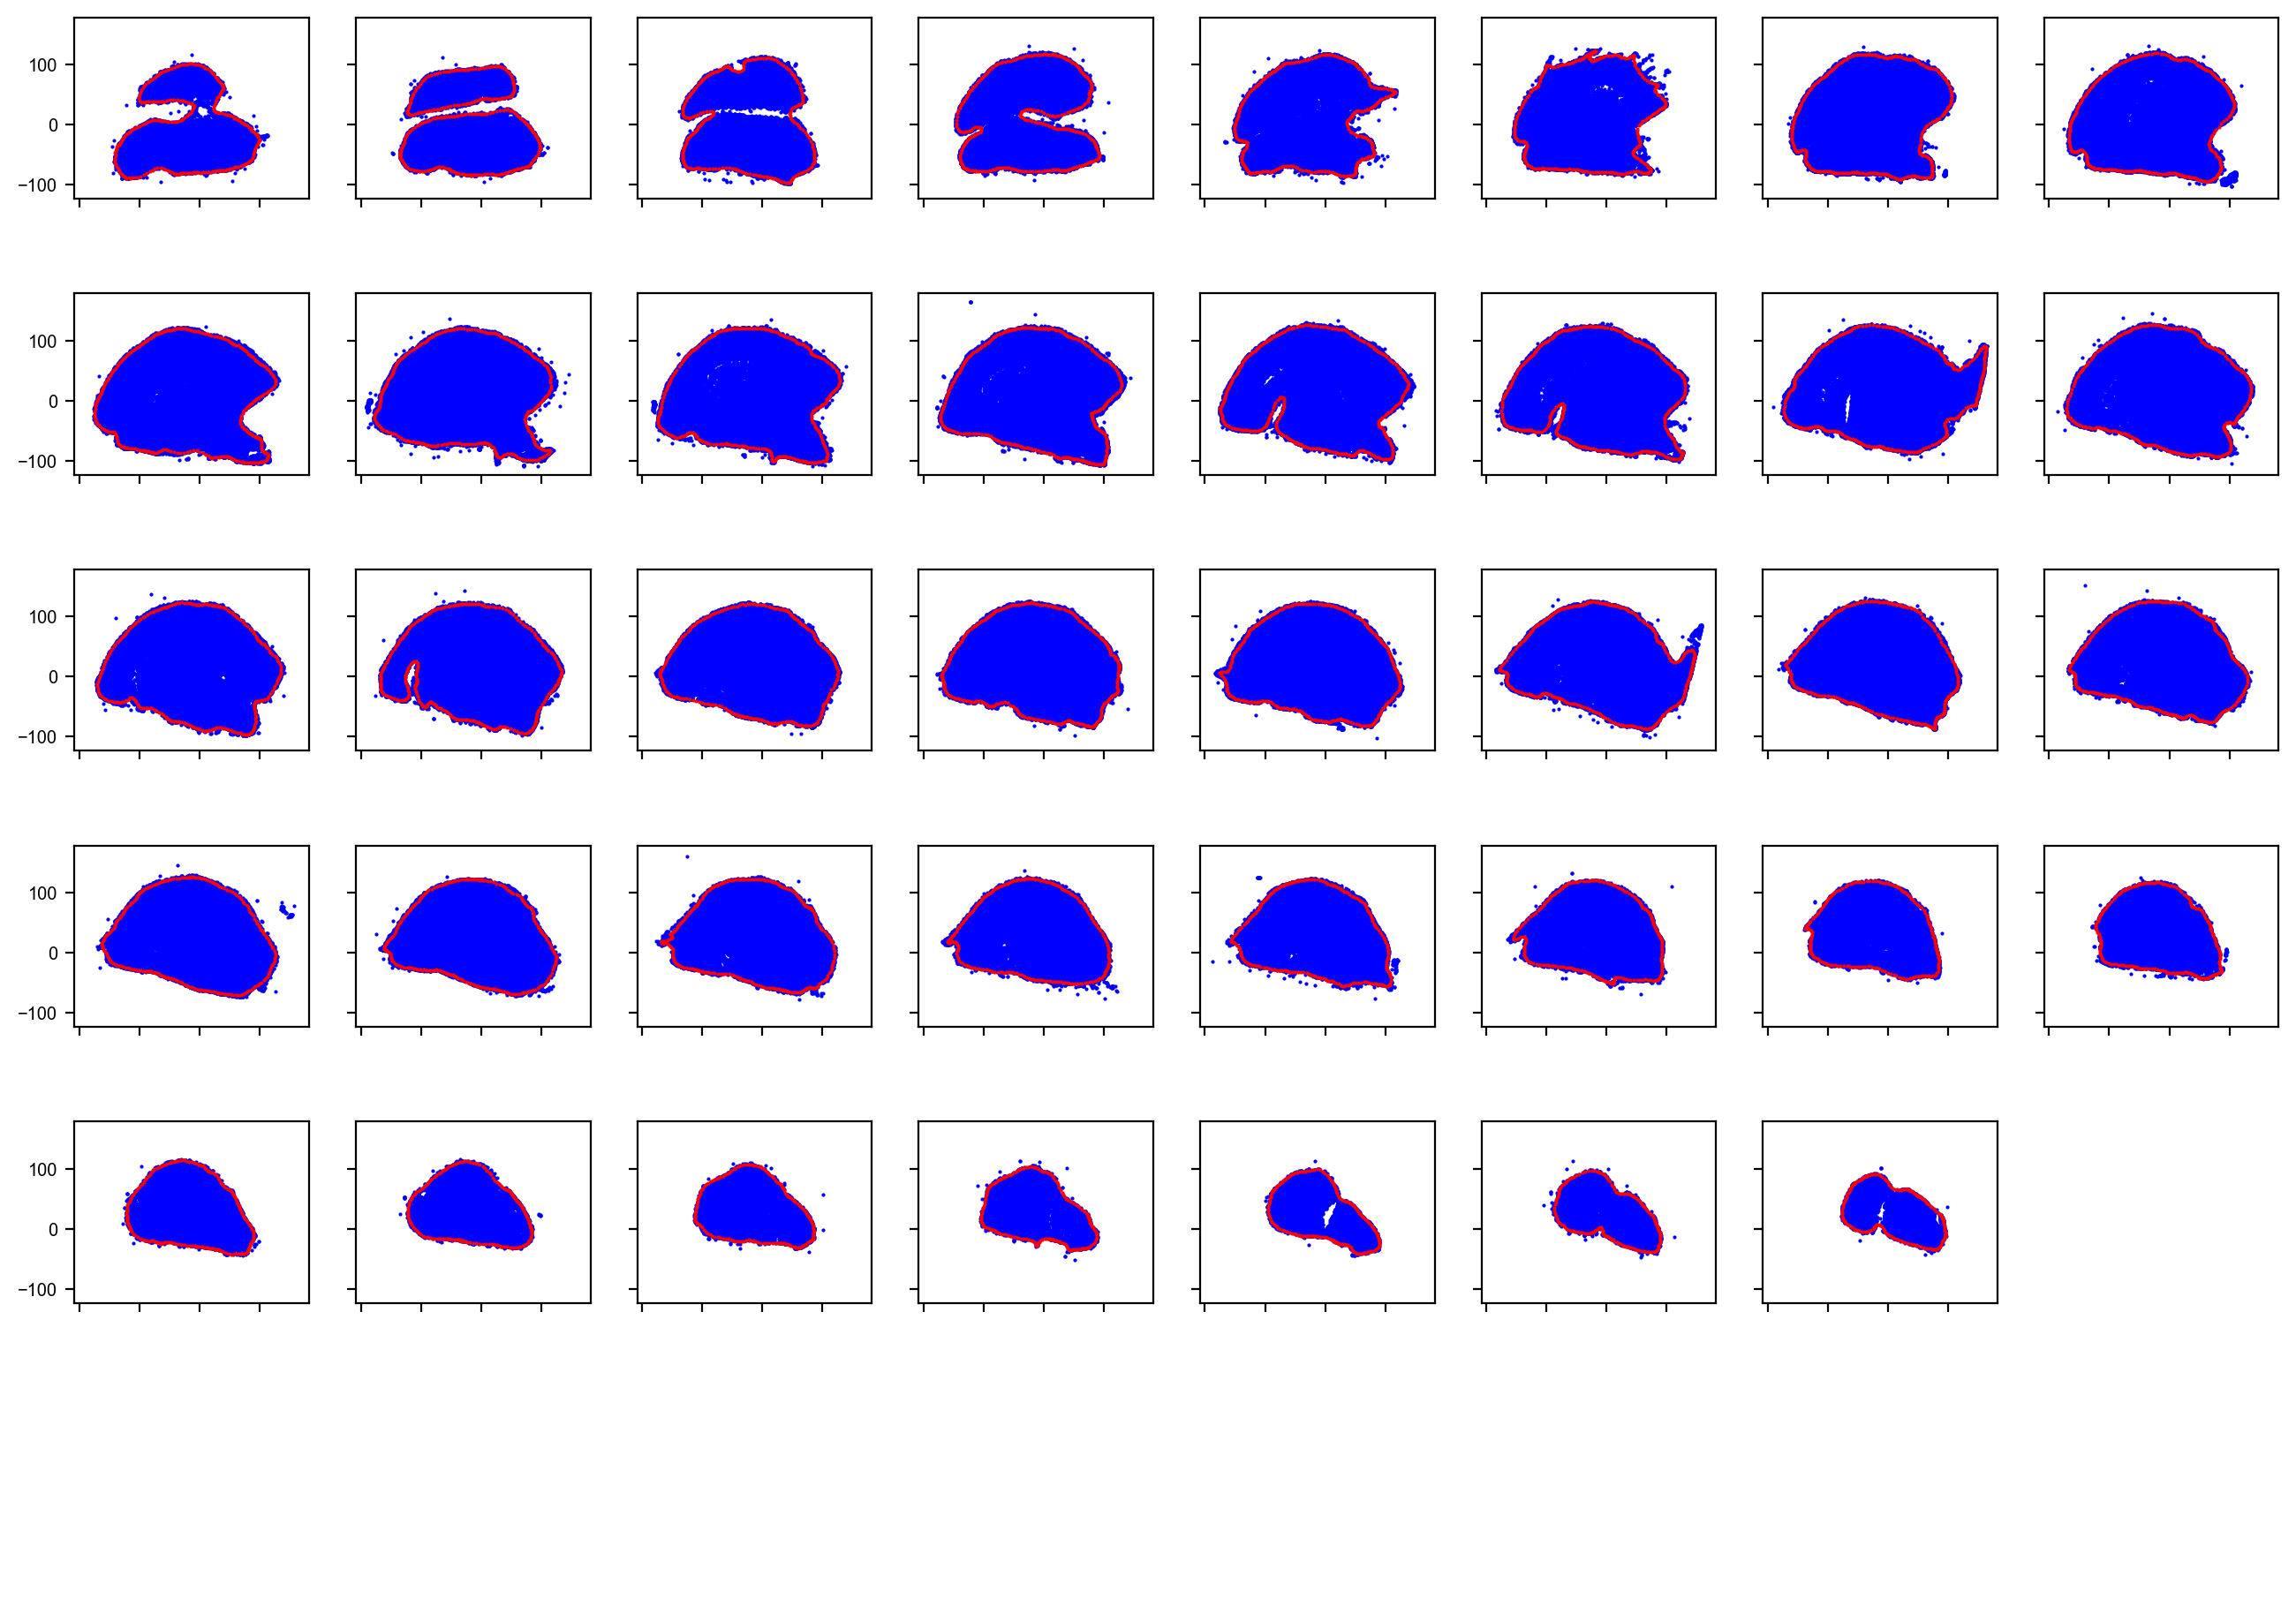

In [35]:
%matplotlib inline
spot_scatter_size = 1
col_num = 8
row_num = len(slices) // col_num + 1
fig, axs = plt.subplots(row_num, col_num, figsize = (col_num*2, row_num*2), sharex=True, sharey=True)
for i in range(col_num * row_num):
    row = i // col_num
    col = i % col_num
    ax = axs[row, col]
    if i < z_shift_correction.n_models - 1:
        points = z_shift_correction.slices_spatial[i]
        contour = z_shift_correction.contours[i]
        ax.scatter(points[:,0],points[:,1],s=spot_scatter_size, color='b')
        ax.scatter(contour[:,0],contour[:,1],s=spot_scatter_size, color='r')
        ax.set_aspect('equal')
    else:
        ax.axis('off')
# plt.savefig(os.path.join(results_folder,'GT_slices.png'), dpi=300, bbox_inches='tight')

In [36]:
# R_shift = z_shift_correction.R_shift
# z_shift = z_shift_correction.z_shift
contours = z_shift_correction.contours
z_values = z_shift_correction.z_values
z_correct_contours_3d = []
for i, (c, z) in enumerate(zip(contours, z_values)):
    # c = (c - z_shift[i]) @ R_shift[i]
    z_correct_contours_3d.append(np.concatenate((c, np.ones((c.shape[0],1))*z), axis=1))
z_correct_contours_3d = np.concatenate(z_correct_contours_3d,axis=0)

In [ ]:
pv.set_jupyter_backend('static')
pl = pv.Plotter(notebook=True,border=True,window_size=[768,768], off_screen=False)
pl.add_mesh(pv.PolyData(z_shift_correction.mesh),color='g',point_size=1.0,render_points_as_spheres=True, ambient=0.5)

pl.add_mesh(pv.PolyData(z_correct_contours_3d),color='r',point_size=2.0,render_points_as_spheres=True)
pl.background_color = 'k'
pl.camera_position = 'yz'
pl.show()

In [ ]:
init_parameters = np.array([0,0,0,0,1])
best_parameters, _ = z_shift_correction.start_discrete_optimization(
    init_parameters=init_parameters,
    max_rotation_angle=5,
    max_translation_scale=0.1,
    max_scaling=1.05,
    labelNum=8,
    nIters=10,
    multi_process=True,
)

In [120]:
z_shift_correction.get_z_shift(smooth=False, allow_rotation=True)

In [121]:
z_shift_correction.z_shift_correction(
    models=slices,
)

In [122]:
R_shift = z_shift_correction.R_shift
z_shift = z_shift_correction.z_shift
contours = z_shift_correction.contours
z_values = z_shift_correction.z_values
z_correct_contours_3d = []
for i, (c, z) in enumerate(zip(contours, z_values)):
    c = (c - z_shift[i]) @ R_shift[i]
    z_correct_contours_3d.append(np.concatenate((c, np.ones((c.shape[0],1))*z), axis=1))

In [ ]:
pv.set_jupyter_backend('panel')
pl = pv.Plotter(notebook=True,border=True,window_size=[768,768], off_screen=False)
pl.add_mesh(pv.PolyData(z_shift_correction.aligned_mesh),color='g',point_size=1.0,render_points_as_spheres=True, ambient=0.5)

pl.add_mesh(pv.PolyData(np.concatenate(z_correct_contours_3d,axis=0)),color='r',point_size=2.0,render_points_as_spheres=True)
pl.background_color = 'k'
pl.camera_position = 'xy'
pl.show()

In [125]:
slices[0]

AnnData object with n_obs × n_vars = 34029 × 114
    obs: 'cluster', 'slice_id', 'simplify_cluster'
    obsm: 'align_spatial', 'perturbed_spatial', 'spatial', 'spatial_CCF', 'spatial_raw', 'align_spatial_z_corrected'

In [128]:
method = 'Spateo'
align_Rotation = []
align_translation = []
for s in slices:
    R, t = solve_RT_by_correspondence(s.obsm['align_spatial_z_corrected'], s.obsm['perturbed_spatial'])
    align_Rotation.append(R)
    align_translation.append(t)
np.save(f'./mesh_corr_results/{method}_mesh_transformation.npy', {'align_Rotation':align_Rotation, 'align_translation':align_translation, 'best_parameters': z_shift_correction.best_parameters}, allow_pickle=True)